# Business Meme Generator using LangGraph and Memegen.link

## Overview
This project demonstrates the creation of a business meme generator that leverages LLMs and the Memegen.link API. By combining LangGraph for workflow management, Groq with `llama-3.1-70b-versatile` for text generation and company information extraction, and Memegen.link for meme creation, we've developed a system that can produce contextually relevant memes based on company website analysis.

## Motivation
In the modern digital marketing landscape, memes have become a powerful tool for brand communication and engagement. This project aims to showcase how AI technologies can be integrated to create a workflow that analyzes a company's online presence and automatically generates relevant, brand-aligned memes. This tool could be valuable for digital marketers, social media managers, and brand strategists looking to create engaging content efficiently.

## Key Components
1. **LangGraph**: Orchestrates the overall workflow, managing the flow of data between different stages of the process.
2. **Llama 3.1 70b (via Groq)**: Analyzes website content and generates meme concepts and text based on company context.
3. **Memegen.link API**: Provides meme templates and handles meme image generation.
4. **Pydantic Models**: Ensures type safety and data validation throughout the workflow.
5. **Asynchronous Programming**: Utilizes `asyncio` and `aiohttp` for efficient parallel processing.

## Method
The meme generation process follows these high-level steps:

1. **Website Analysis**:
   - Fetches and analyzes the company's website content
   - Extracts key information about brand tone, target audience, and value proposition

2. **Context Generation**:
   - Creates a structured company context including:
     - Brand tone of voice
     - Target audience
     - Value proposition
     - Key products/services
     - Brand personality traits

3. **Meme Concept Creation**:
   - Generates multiple meme concepts based on the company context
   - Each concept includes:
     - Main message/joke
     - Intended emotional response
     - Audience relevance

4. **Template Selection**:
   - Fetches available meme templates from Memegen.link
   - Matches concepts with appropriate templates based on context

5. **Text Generation**:
   - Creates contextually appropriate text for each meme
   - Ensures alignment with brand voice and message

6. **Meme Assembly**:
   - Combines selected templates with generated text
   - Creates final meme URLs using Memegen.link API

## Data Structures
The project uses several key Pydantic models for data validation:

1. **CompanyContext**:
   - Structured representation of company information
   - Includes tone, target audience, value proposition, etc.

2. **MemeConcept**:
   - Represents individual meme ideas
   - Contains message, emotion, and audience relevance

3. **TemplateInfo**:
   - Stores meme template metadata
   - Includes template ID, name, description, and example text

4. **GeneratedMeme**:
   - Final meme output structure
   - Contains all template and text information plus final URL

## Workflow Components
The LangGraph workflow consists of several key nodes:

1. `get_website_content`:
   - Fetches and processes website content
   - Handles URL validation and content extraction

2. `analyze_company_insights`:
   - Processes website content into structured company context
   - Uses LLM for content analysis

3. `generate_meme_concepts`:
   - Creates meme concepts based on company context
   - Ensures brand alignment

4. `select_meme_templates`:
   - Matches concepts with appropriate templates
   - Handles template filtering and selection

5. `generate_text_elements`:
   - Creates meme text based on concepts and templates
   - Maintains brand voice consistency

6. `create_meme_url`:
   - Generates final meme URLs
   - Handles URL encoding and formatting

## Usage
The system can be used by providing a company website URL:

```python
website_url = "https://www.langchain.com"
result = await run_workflow(website_url)
```

The workflow will analyze the website, generate appropriate memes, and display:
- Company context analysis
- Generated meme concepts
- Final memes with captions
- Meme preview images

## Conclusion
This Business Meme Generator demonstrates the potential of combining different technologies with AI to create a powerful content generation tool. The modular nature of the system, facilitated by LangGraph, allows for easy updates or replacements of individual components as technologies evolve.

The project shows how AI can assist in creative tasks while maintaining brand consistency and relevance. Future enhancements could include:
- Additional template sources
- More sophisticated brand analysis
- Integration with social media accounts to better understand brand voice
- User feedback integration
- Custom template upload capabilities

As AI continues to evolve, tools like this will become increasingly valuable for digital marketing and brand communication strategies.

## Installing Libraries
Intall necessary libraries.



In [ ]:
!pip install langgraph langchain_groq langchain_core IPython python-dotenv groq langchain_community

## Import Dependencies

This cell imports all necessary libraries and sets up the environment.


In [3]:
import os
from typing import TypedDict, Annotated, Sequence, List, Dict, Any, Optional
from langgraph.graph import Graph, END
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, AIMessage
from groq import Groq
from PIL import Image
import io
from IPython.display import display, Image as IPImage
from langchain_community.document_loaders import WebBaseLoader
from pydantic import BaseModel, Field

from langchain_core.runnables.graph import MermaidDrawMethod
import asyncio
import aiohttp
import json
import requests
import random
from io import BytesIO
from dotenv import load_dotenv
import re
from urllib.parse import quote


# Load environment variables
load_dotenv()

# Set GROQ API key
os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')

# Initialize GROQ client
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))


## Define Data Structures and GraphState

Define the data structure template models for validation using Pydantic models and graph state using TypedDict.

In [4]:
# Template structures
class CompanyContext(BaseModel):
    """Company context to be used to generate memes."""
    tone: str = Field(description = "The tone of voice of the company")
    target_audience: str = Field(description = "The target audience of the company")
    value_proposition: str = Field(description = "The value proposition of the company")
    key_products: List[str] = Field(description = "A list with the company's key products")
    brand_personality: str = Field(description = "The brand personality of the company")

class MemeConcept(BaseModel):
    message: str = Field(description="The core message of the meme")
    emotion: str = Field(description="The emotion conveyed by the meme")
    audience_relevance: str = Field(description="The relevance of the meme to the audience")

class MemeConcepts(BaseModel):
    concepts: List[MemeConcept] = Field(description="List of meme concepts")

class TemplateInfo(BaseModel):
    template_id: str = Field(..., description="Unique identifier for the template")
    name: str = Field(..., description="Name of the meme template")
    blank_template_api_link: str = Field(..., description="API link to the blank template")
    description: str = Field(..., description="Description of the meme template")
    example_text_1: Optional[str] = Field("", description="Example text for the first line")
    example_text_2: Optional[str] = Field("", description="Example text for the second line")
    lines: int = Field(..., description="Number of text lines in the meme")
    keywords: List[str] = Field(..., description="Keywords associated with the template")

class SelectedMeme(BaseModel):
    meme_id: str = Field(..., description="Unique identifier for the selected meme")
    template_id: str = Field(..., description="ID of the selected template")
    concept: MemeConcept = Field(..., description="The concept associated with the meme")
    is_text_element1_filled: bool = Field(..., description="Indicates if the first text element is filled")
    is_text_element2_filled: bool = Field(..., description="Indicates if the second text element is filled")
    example_text_1: Optional[str] = Field("", description="Example text for the first line")
    example_text_2: Optional[str] = Field("", description="Example text for the second line")
    template_info: TemplateInfo = Field(..., description="Information about the selected template")
    blank_template_api_link: str = Field(..., description="API link to the blank template without extension")
    blank_template_api_link_extension: str = Field(..., description="File extension of the blank template link")

class PreGeneratedMeme(BaseModel):
    meme_id: str = Field(..., description="Unique identifier for the selected meme")
    template_id: str = Field(..., description="ID of the selected template")
    concept: MemeConcept = Field(..., description="The concept associated with the meme")
    is_text_element1_filled: bool = Field(..., description="Indicates if the first text element is filled")
    is_text_element2_filled: bool = Field(..., description="Indicates if the second text element is filled")
    template_info: TemplateInfo = Field(..., description="Information about the selected template")
    blank_template_api_link: str = Field(..., description="API link to the blank template without extension")
    blank_template_api_link_extension: str = Field(..., description="File extension of the blank template link")
    generated_text_element1: str = Field(..., description="Generated text element 1")
    generated_text_element2: str = Field(..., description="Generated text element 2")

class GeneratedMeme(BaseModel):
    meme_id: str = Field(..., description="Unique identifier for the selected meme")
    template_id: str = Field(..., description="ID of the selected template")
    concept: MemeConcept = Field(..., description="The concept associated with the meme")
    is_text_element1_filled: bool = Field(..., description="Indicates if the first text element is filled")
    is_text_element2_filled: bool = Field(..., description="Indicates if the second text element is filled")
    template_info: TemplateInfo = Field(..., description="Information about the selected template")
    blank_template_api_link: str = Field(..., description="API link to the blank template without extension")
    blank_template_api_link_extension: str = Field(..., description="File extension of the blank template link")
    generated_text_element1: str = Field(..., description="Generated text element 1")
    generated_text_element2: str = Field(..., description="Generated text element 2")
    treated_text_element1: str = Field(..., description="Treated text element 1")
    treated_text_element2: str = Field(..., description="Treated text element 2")
    final_url: str = Field(..., description="Final URL of the generated meme")

# Graph State
class GraphState(TypedDict):
    """Enhanced state object for the meme generation workflow."""
    messages: Annotated[Sequence[HumanMessage | AIMessage], "Conversation messages"]
    website_url: Annotated[str, "Company website URL"]
    website_content: Annotated[List, "Website content"]
    company_context: Annotated[Dict[str, Any], "Analyzed company information"]
    meme_concepts: Annotated[List[dict], "Generated meme concepts"]
    selected_concepts: Annotated[List[dict], "Selected top 3 meme concepts"]
    selected_memes: Annotated[Dict[str, SelectedMeme], "Selected memes with their info"]
    pre_generated_memes: Annotated[Dict[str, PreGeneratedMeme], "Pre-Generated memes with their info"]
    generated_memes: Annotated[Dict[str, GeneratedMeme], "Pre-Generated memes with their info"]
    available_templates: Annotated[Dict[str, TemplateInfo], "Available meme templates"]

# Initialize the language model
llm = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0.7,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

## Define Graph Functions

Define the functions that will be used in the LangGraph workflow.

In [5]:
def ensure_url(string: str) -> str:
    """
    Ensures a given string is a properly formatted URL by adding 'http://' if needed
    and validating the URL format.

    Args:
        string (str): The URL string to validate and format

    Returns:
        str: A properly formatted URL

    Raises:
        ValueError: If the URL format is invalid

    Example:
        >>> ensure_url("example.com")
        'http://example.com'
        >>> ensure_url("https://example.com")
        'https://example.com'
    """

    if not string.startswith(("http://", "https://")):
        string = "http://" + string

    # Basic URL validation regex
    url_regex = re.compile(
        r"^(https?:\/\/)?"  # optional protocol
        r"(www\.)?"  # optional www
        r"([a-zA-Z0-9.-]+)"  # domain
        r"(\.[a-zA-Z]{2,})?"  # top-level domain
        r"(:\d+)?"  # optional port
        r"(\/[^\s]*)?$",  # optional path
        re.IGNORECASE,
    )

    if not url_regex.match(string):
        msg = f"Invalid URL: {string}"
        raise ValueError(msg)

    return string

async def get_website_content(state: GraphState) -> GraphState:
    """
    Fetches and analyzes website content using WebBaseLoader.

    Args:
        state (GraphState): Current workflow state containing website_url

    Returns:
        GraphState: Updated state with website_content added

    Notes:
        - Uses WebBaseLoader to fetch HTML content
        - Handles encoding with utf-8
        - Updates state with combined text content from all pages
        - Handles errors and updates state with error message if fetch fails
    """

    try:
        # Ensure URL is properly formatted
        website_url = state["website_url"]
        validated_url = ensure_url(website_url)

        # Get text content
        web_loader = WebBaseLoader(web_paths=[validated_url], encoding="utf-8")
        text_docs = web_loader.load()

        # Extract content from all documents
        content = []
        for doc in text_docs:
            content.append(doc.page_content)

        # Store combined content in state
        state["website_content"] = "\n\n".join(content)
        return state

    except Exception as e:
        print(f"Error fetching website content: {str(e)}")
        state["website_content"] = f"Error fetching content from {website_url}: {str(e)}"
        return state

def analyze_company_insights(state: GraphState) -> GraphState:
    """
    Analyzes company information from website content using LLM.

    Args:
        state (GraphState): Current state containing website_content

    Returns:
        GraphState: Updated state with company_context added

    Notes:
        - Uses structured LLM output for consistent format
        - Analyzes tone, target audience, value proposition, key products, and brand personality
        - Handles cases where no content is available
    """

    # Extract search results from state
    website_data = state.get("website_content")
    if not website_data:
        state["company_context"] = {"error": "No content available to analyze."}
        return state

    content = website_data[0]

    prompt = f"""Analyze this company website content and provide insights in a JSON format with the following structure:
    {{
        "tone": "string describing the brand tone of voice (professional, casual, technical, etc.)",
        "target_audience": "string describing target audience/persona",
        "value_proposition": "string describing their unique value proposition",
        "key_products": ["array", "of", "key", "products", "or", "services"],
        "brand_personality": "string describing 3-5 key brand personality traits"
    }}

    Website Content:
    {website_data}

    Please ensure key_products is always returned as an array/list, even if there's only one product.
    Be specific and base insights on the actual content."""

    structured_llm = llm.with_structured_output(CompanyContext)

    response = structured_llm.invoke([HumanMessage(content=prompt)])
    state["company_context"] = response

    return state

def generate_meme_concepts(state: GraphState) -> GraphState:
    """
    Generates meme concepts based on analyzed company insights.

    Args:
        state (GraphState): Current state containing company_context

    Returns:
        GraphState: Updated state with meme_concepts and selected_concepts added

    Notes:
        - Creates 3 meme concepts based on company insights
        - Each concept includes message, emotion, and audience relevance
        - Parses JSON response to extract structured concepts
        - Selects top 3 concepts for further processing
    """

    insights = state["company_context"]

    prompt = f"""Create 3 meme concepts based on these company insights:

    Tone: {insights.tone}
    Target Audience: {insights.target_audience}
    Value Proposition: {insights.value_proposition}
    Key Products: {', '.join(insights.key_products)}
    Brand Personality: {insights.brand_personality}

    For each meme concept, provide:
    1. The main message/joke
    2. The intended emotional response
    3. How it relates to the target audience

    Format the response as JSON array with structure:
    [{{"message": "string", "emotion": "string", "audience_relevance": "string"}}]"""

    response = llm.invoke([HumanMessage(content=prompt)])

    # Find JSON array in response using regex
    json_match = re.search(r'\[\s*{.*}\s*\]', response.content, re.DOTALL)
    if json_match:
        concepts_json = json_match.group(0)
        try:
            concepts = json.loads(concepts_json)
            state["meme_concepts"] = concepts
            state["selected_concepts"] = concepts[:3]  # Select top 3 concepts
            return state
        except json.JSONDecodeError:
            print("Failed to parse JSON response")

    return state

async def get_meme_templates() -> Dict[str, TemplateInfo]:
    """
    Fetches available meme templates from Memegen.link API.

    Returns:
        Dict[str, TemplateInfo]: Dictionary of template information keyed by template ID

    Notes:
        - Fetches templates from Memegen.link API
        - Filters templates to those with 2 or fewer lines
        - Randomly selects 20 templates
        - Converts API response to TemplateInfo objects
        - Includes template metadata like name, description, and example text
    """

    async with aiohttp.ClientSession() as session:
        async with session.get("https://api.memegen.link/templates/") as response:
            all_templates = await response.json()

            # Filter templates with 2 or fewer lines
            filtered_templates = [
                template for template in all_templates
                if template.get("lines", 0) <= 2
            ]

            # Select 20 random templates
            selected_templates = random.sample(filtered_templates, min(20, len(filtered_templates)))

            # Convert to dictionary with template ID as key, mapping fields to TemplateInfo
            template_dict = {
                template["id"]: TemplateInfo(
                    template_id=template["id"],
                    name=template["name"],
                    blank_template_api_link=template["blank"],
                    description=f"{template['name']} meme with {template['lines']} text lines.",
                    example_text_1=template.get('example', {}).get('text', [''])[0] or '',
                    example_text_2=template.get('example', {}).get('text', ['', ''])[1] if len(template.get('example', {}).get('text', [])) > 1 else '',
                    lines=template["lines"],
                    keywords=template.get("keywords", [])
                )
                for template in selected_templates
            }
            return template_dict

def select_meme_templates(state: GraphState) -> GraphState:
    """
    Selects appropriate meme templates for each concept.

    Args:
        state (GraphState): Current state containing selected_concepts and available_templates

    Returns:
        GraphState: Updated state with selected_memes added

    Notes:
        - Creates simplified template descriptions for LLM
        - Matches concepts with appropriate templates
        - Falls back to random selection if no match found
        - Handles template selection for each concept
        - Creates structured meme objects with template info
    """

    concepts = state["selected_concepts"]
    templates = state["available_templates"]
    selected_memes = {}

    # Create simplified template descriptions for the LLM
    template_descriptions = [
        {
            'template_id': template_id,
            'name': template_data.name,
            'description': template_data.description,
            'lines': template_data.lines
        }
        for template_id, template_data in templates.items()
    ]

    for idx, concept in enumerate(concepts):
        prompt = f"""Select a meme template that best fits this concept:

        Concept:
        - Message: {concept['message']}
        - Emotion: {concept['emotion']}
        - Audience Relevance: {concept['audience_relevance']}

        Available Templates:
        {json.dumps(template_descriptions, indent=2)}

        Return only the template ID that best matches the concept's message and emotion."""

        try:
            response = llm.invoke([HumanMessage(content=prompt)])
            # Extract template ID from response, removing quotes and whitespace
            template_id = response.content.strip().strip('"').strip("'").lower()

            # Fallback to random template if not found
            if template_id not in templates:
                template_id = random.choice(list(templates.keys()))

            # Create meme object
            selected_memes[f"meme_{idx+1}"] = {
                "meme_id": f"meme_{idx+1}",
                "template_id": template_id,
                "concept": concept,
                "template_info": templates[template_id],
                "blank_template_api_link": templates[template_id].blank_template_api_link,
                "is_text_element1_filled": True,
                "is_text_element2_filled": templates[template_id].lines >= 2
            }

        except Exception as e:
            print(f"Error selecting template: {str(e)}")
            continue

    state["selected_memes"] = selected_memes
    return state

def generate_text_elements(state: GraphState) -> GraphState:
    """
    Generates meme text based on selected concepts and templates.

    Args:
        state (GraphState): Current state containing selected_memes and company_context

    Returns:
        GraphState: Updated state with pre_generated_memes added

    Notes:
        - Generates appropriate text for each template
        - Considers template format and number of lines
        - Maintains brand tone and target audience
        - Creates concise, punchy text elements
        - Handles errors gracefully for each meme
    """

    selected_memes = state["selected_memes"]
    context = state["company_context"]
    pre_generated_memes = {}

    for meme_id, meme in selected_memes.items():
        concept = meme["concept"]
        template_info = meme["template_info"]

        prompt = f"""Create text for a meme based on this template and concept:

        Template: {template_info.name}
        Number of lines: {template_info.lines}
        Example Text 1: {template_info.example_text_1}
        Example Text 2: {template_info.example_text_2}
        Concept Message: {concept['message']}
        Emotion: {concept['emotion']}

        Company Context:
        Target Audience: {context.target_audience}
        Brand Tone: {context.tone}

        Return ONLY the text lines, one per line. Keep each line concise and punchy.

        """

        try:
            response = llm.invoke([HumanMessage(content=prompt)])
            text_elements = response.content.strip().split('\n')

            generated_text1 = text_elements[0] if len(text_elements) > 0 else ""
            generated_text2 = text_elements[1] if len(text_elements) > 1 else ""

            pre_generated_memes[meme_id] = {
                **meme,
                "generated_text_element1": generated_text1,
                "generated_text_element2": generated_text2
            }

        except Exception as e:
            print(f"Error generating text: {str(e)}")
            continue

    state["pre_generated_memes"] = pre_generated_memes
    return state

def create_meme_url(state: GraphState) -> GraphState:
    """
    Creates final meme URLs using the Memegen.link API format.

    Args:
        state (GraphState): Current state containing pre_generated_memes

    Returns:
        GraphState: Updated state with generated_memes added

    Notes:
        - Processes text elements for URL compatibility
        - Handles URL encoding of text
        - Extracts and manages file extensions
        - Constructs final meme URLs
        - Maintains all meme metadata in state
    """

    pre_generated_memes = state["pre_generated_memes"]
    generated_memes = {}

    for meme_id, meme in pre_generated_memes.items():
        # Process text elements
        text1 = quote(meme["generated_text_element1"].replace(' ', '_'))
        text2 = quote(meme["generated_text_element2"].replace(' ', '_'))

        # Get template info
        template_info = meme["template_info"]
        base_url = template_info.blank_template_api_link

        # Extract extension
        extension = os.path.splitext(base_url)[1]
        base_url = base_url.rsplit('.', 1)[0]

        # Construct final URL
        final_url = f"{base_url}/{text1}/{text2}{extension}"

        generated_memes[meme_id] = {
            **meme,
            "final_url": final_url,
            "text_elements": [text1, text2]
        }

    state["generated_memes"] = generated_memes
    return state

async def display_meme(url: str):
    """
    Displays a meme from a given URL.

    Args:
        url (str): URL of the meme to display

    Returns:
        Optional[Image.Image]: PIL Image object if successful, None if failed

    Notes:
        - Fetches image data asynchronously
        - Converts bytes to PIL Image
        - Handles HTTP errors
        - Reports failures without crashing
    """

    try:
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                if response.status == 200:
                    image_data = await response.read()
                    image = Image.open(BytesIO(image_data))
                    return image
                else:
                    print(f"Failed to fetch image: Status {response.status}")
                    return None
    except Exception as e:
        print(f"Error displaying meme: {str(e)}")
        return None

## Set Up LangGraph Workflow

Define the LangGraph workflow by adding nodes and edges.

In [6]:
workflow = Graph()

# Add nodes
workflow.add_node("get_website_content", get_website_content)
workflow.add_node("analyze_company", analyze_company_insights)
workflow.add_node("generate_concepts", generate_meme_concepts)
workflow.add_node("select_templates", select_meme_templates)
workflow.add_node("generate_text", generate_text_elements)
workflow.add_node("create_url", create_meme_url)

# Add edges
workflow.add_edge("get_website_content", "analyze_company")
workflow.add_edge("analyze_company", "generate_concepts")
workflow.add_edge("generate_concepts", "select_templates")
workflow.add_edge("select_templates", "generate_text")
workflow.add_edge("generate_text", "create_url")
workflow.add_edge("create_url", END)

# Set entry point
workflow.set_entry_point("get_website_content")

# Compile the workflow
app = workflow.compile()


## Display Graph Structure

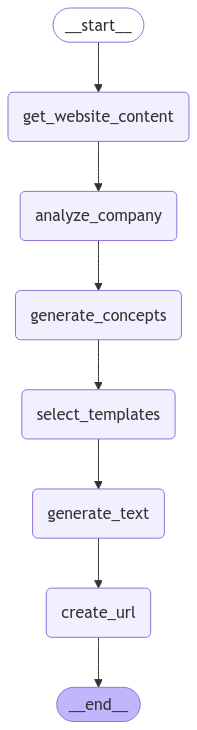

In [7]:
display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run Workflow Function

Define a function to run the workflow and display results.

In [8]:
async def run_workflow(website_url: str):
    """
    Runs the complete meme generation workflow.

    Args:
        website_url (str): URL of the company website to analyze

    Returns:
        Complete workflow results or None if failed

    Notes:
        - Initializes workflow with available templates
        - Sets up initial state
        - Runs complete LangGraph workflow
        - Displays results including:
            - Company analysis
            - Generated memes
            - Preview images
        - Handles and reports errors
        - Returns full result data
    """

    # Get available templates
    print("Loading meme templates...")
    available_templates = await get_meme_templates()

    initial_state = {
        "messages": [],
        "website_url": website_url,
        "website_content": "",
        "company_context": {
            "tone": "",
            "target_audience": "",
            "value_proposition": "",
            "key_products": [],
            "brand_personality": ""
        },
        "meme_concepts": [],
        "selected_concepts": [],
        "selected_memes": {},
        "generated_memes": {},
        "available_templates": available_templates
    }

    try:

        # Run workflow
        result = await app.ainvoke(initial_state)

        # Display results
        if isinstance(result, dict) and "company_context" in result:
            print("\nCompany Analysis:")
            print("")
            for key, value in result["company_context"]:
                print(f"{key.title()}: {value}")

            if "generated_memes" in result:
                print("\nGenerated Memes:")
                for meme_id, meme_info in result["generated_memes"].items():
                    print(f"\n{meme_id.upper()}:")
                    print("")
                    template_info = meme_info.get('template_info', {})
                    print(f"Template: {template_info.name}")
                    print(f"Blank template image: {template_info.blank_template_api_link}")
                    print("")
                    print(f"Concept message: {meme_info['concept']['message']}")
                    print(f"Concept emotion: {meme_info['concept']['emotion']}")
                    print(f"Concept audience relevance: {meme_info['concept']['audience_relevance']}")
                    print("")
                    print(f"Generated captions:")
                    print(meme_info["generated_text_element1"])
                    print(meme_info["generated_text_element2"])
                    print(f"URL: {meme_info['final_url']}")
                    print("")
                    meme_image = await display_meme(meme_info["final_url"])
                    if meme_image:
                      display(meme_image)
                    else:
                      print(f"Failed to display {meme_id}")
                    print("--------------------------------------------------------------------------")
        return result

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

## Execute Workflow

Run the workflow with a sample query.



Generating memes for: https://www.langchain.com/
Loading meme templates...

Company Analysis:

Tone: technical and professional
Target_Audience: developers and enterprises working with large language models
Value_Proposition: enabling developers to build, run, and manage LLM applications with a suite of products that support each step of the application lifecycle
Key_Products: ['LangChain', 'LangSmith', 'LangGraph']
Brand_Personality: innovative, collaborative, and solution-focused

Generated Memes:

MEME_1:

Template: Condescending Wonka
Blank template image: https://api.memegen.link/images/wonka.png

Concept message: When you finally deploy your LLM app, but then you have to manage it
Concept emotion: Relatability and mild frustration, followed by relief when our products are introduced as a solution
Concept audience relevance: Developers working with large language models often struggle with managing their applications after deployment. This meme acknowledges that struggle and sets 

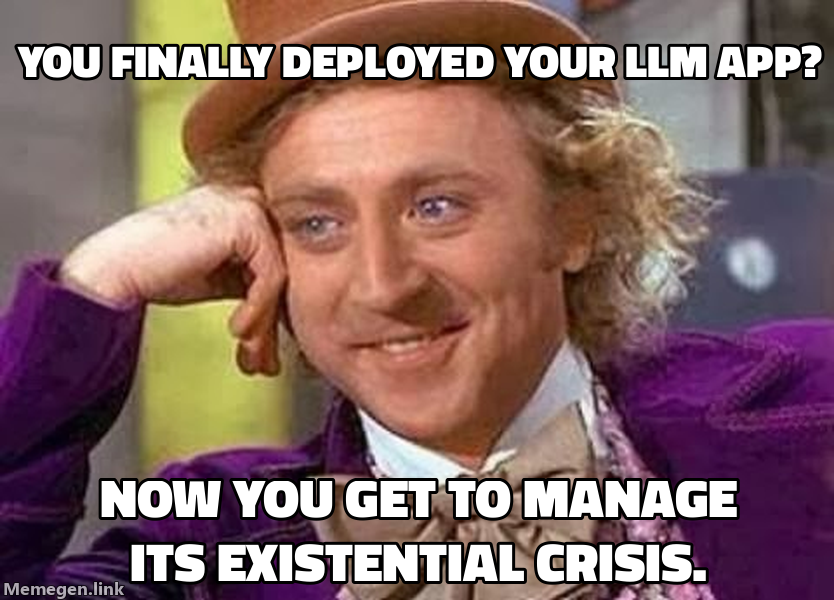

--------------------------------------------------------------------------

MEME_2:

Template: Foul Bachelor Frog
Blank template image: https://api.memegen.link/images/fbf.png

Concept message: Me trying to build an LLM app from scratch vs. Me using LangChain, LangSmith, and LangGraph
Concept emotion: Amusement and a sense of 'aha!' when they see how much easier their lives can be with our products
Concept audience relevance: Developers often spend a lot of time and effort building applications from scratch. This meme highlights the difference between that struggle and the ease of using our products, making it relatable and appealing to our target audience.

Generated captions:
Me trying to build an LLM from scratch
Me using LangChain, LangSmith, and LangGraph
URL: https://api.memegen.link/images/fbf/Me_trying_to_build_an_LLM_from_scratch/Me_using_LangChain%2C_LangSmith%2C_and_LangGraph.png



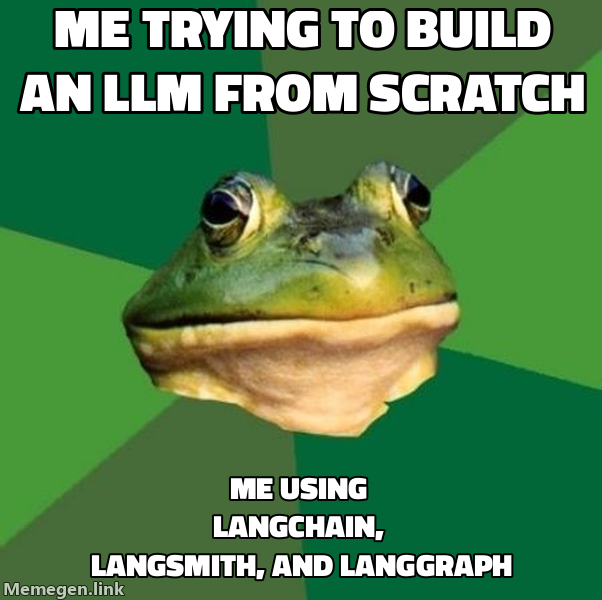

--------------------------------------------------------------------------

MEME_3:

Template: Laundry Room Viking
Blank template image: https://api.memegen.link/images/lrv.png

Concept message: When your LLM app is working perfectly, but then you have to explain it to your non-technical colleagues
Concept emotion: Laughter and solidarity
Concept audience relevance: Developers working with LLMs often have to communicate complex technical concepts to non-technical stakeholders. This meme pokes fun at that challenge and positions our products as a way to simplify those conversations by making LLM applications more manageable and accessible.

Generated captions:
train the model they said
explain it to non-techs they said
URL: https://api.memegen.link/images/lrv/train_the_model_they_said/explain_it_to_non-techs_they_said.png



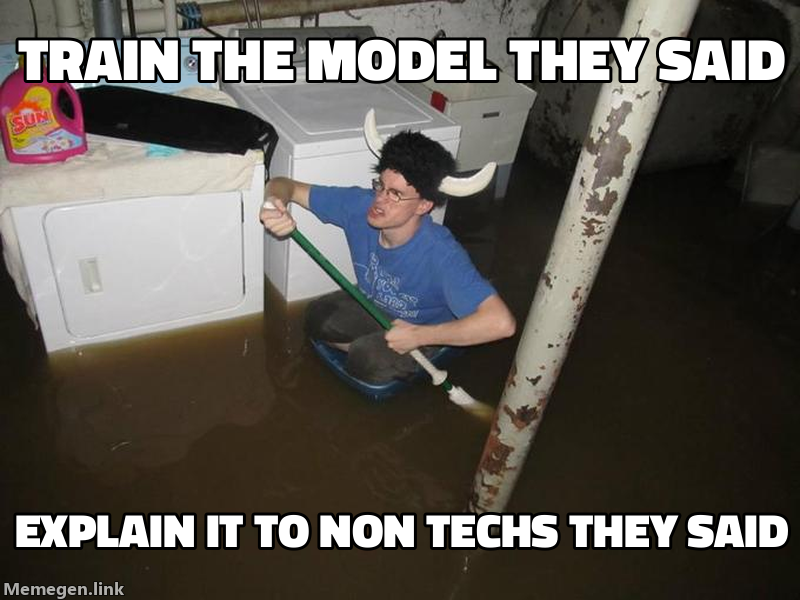

--------------------------------------------------------------------------

Workflow completed successfully!


In [9]:
website_url = "https://www.langchain.com/"
print(f"Generating memes for: {website_url}")
result = await run_workflow(website_url)

if result:
    print("\nWorkflow completed successfully!")
else:
    print("\nWorkflow failed. Please check the error messages above.")